Hieu Nguyen

nguyenhieu@uchicago.edu

Problem Set 2

TTIC Deep Learning, Fall 2024

# Instructions

For this assignment you will use PyTorch instead of EDF to implement and train neural networks. The experiments in this assignment will take a long time to run without a GPU, but you can run the notebook remotely on Google Colab and have access to GPUs for free -- in this case you don't have to worry about installing PyTorch as it is available by default in Google Colab's environment.

To use Google Colab, you should access https://colab.research.google.com/ and upload this notebook to your workspace. To use a GPU, go to Edit -> Notebook settings and select GPU as the accelerator.

In case you will be running the experiments in your own machine, you should install PyTorch -- there are multiple tutorials online and it is especially easy if you're using Anaconda. However, running on colab ensures that you are running in the same environment (e.g., same python version) that the homework was developed in.

You can check out pytorch tutorials at https://pytorch.org/tutorials/.

In [1]:
import torch, math, copy
import numpy as np
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F

loading the mnist data

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = datasets.MNIST("data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST("data", train=False, download=True, transform=transform)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.68MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 136kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:06<00:00, 244kB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 11.6MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [3]:
print(train_dataset.data.shape, test_dataset.data.shape)

train_dataset.data[0].shape

torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])


torch.Size([28, 28])

The pytorch works with modules which are instances of the class [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html).

A module class holds a parameter shape and a forward method. An instance of a module holds trainable parameters.  Creating an instance of a module allocates fresh parameters.  A module also includes a call method (automatically created) that allows an instance of the module to be applied like a function to an input.

This is different from EDF.  In EDF the forward method accesses the input as an instance variable of the object rather than as an argument to an application of a module instance. A parameter package of EDF is somewhat analogous to a module instance in PyTorch.

For the module class "compose" given below each instance of the module has instance variables f and g which are also modules.


In [4]:
class compose(nn.Module):
    def __init__(self,f,g):
        super().__init__()
        self.f = f
        self.g = g
    def forward(self, input):
        return self.f(self.g(input))

We now use compose to build networks.  This is somewhat non-standard but seems elegant.





In [5]:
# each stack has specific nchannels_out, so all layers within have the same neurons/channels

def simple_stack(depth,nchannels_in,nchannels_out,kernel_dim,activation):
  if(depth  == 1):
    # first layer: stride=2 (downsamnpling)
     return compose(activation,
                    nn.Conv2d(nchannels_in,
                              nchannels_out,
                              kernel_dim,
                              stride = 2,
                              padding = int(kernel_dim/2)))
  return compose(simple_stack(depth-1,nchannels_in,nchannels_out,kernel_dim,
                              activation),
                 compose(activation,
                         nn.Conv2d(nchannels_in,
                         nchannels_in,
                         kernel_dim,
                         stride = 1,
                         padding = int(kernel_dim/2))))

I also found an on-line discussion of initialization in PyTorch stating that "The docs usually don’t mention the initialization method, but if you look at PyTorch’s source code, you can see the weights are initialized with Kaiming uniform initialization."

This is called He initialization in the course slides (his name is Kaiming He). Xavier initialization is similar.



In [6]:
# initialize initial parameters/weights

def PS2_CNN(stackdepth, kernel_dim, activation):
    """
    By default, Pytorch already intializes first set of weights with He initialization
     for every layer.
    This architecture only serves as a way to deal with input data like dimensions,
    residual connection, kernel, so on; it's not training the weights yet
    """
    #input.shape is [nbatch, 28,28, n=1]

    #L_1
    u = compose(activation, nn.Conv2d(1, 4, kernel_dim, 2, 1)) # do u on input data
    # u(as an input for next stack/layers).shape = [nbatch,14,14, n=4] because of
    # stride 2
    # (reduce spatial dimension from 28x28 to 14x14 AND increase n=4 to n=8)

    # L2, L3, L4
    u = compose(simple_stack(stackdepth, 4, 8, kernel_dim, activation), u)
    # u(input).shape = [nbatch, 7,7, n=8]

    # L5, L6, L7
    u = compose(simple_stack(stackdepth, 8, 16, kernel_dim, activation), u)
    # u(input).shape = [nbatch, 4,4, n=16]

    # L8, L9, L10
    u = compose(simple_stack(stackdepth, 16, 32, kernel_dim, activation), u)
    # u(input).shape = [nbatch, 2,2, n=32]

    # L11 flattened
    u = compose(nn.Flatten(1), u);
    # u(input).shape = [nbatch, 128]

    # L12 output fully connected
    u = compose(nn.Linear(128, 10), u)
    # u(input).shape = [nbatch, 10]

    return u

# channels/neurons change: 1->4, 4->8, 8->16, 16->32, 2x2x32->128 flat, 128->10

In [7]:
model = PS2_CNN(1, 3, nn.ReLU())

for p in model.parameters():
    print(p.shape)

torch.Size([10, 128])
torch.Size([10])
torch.Size([32, 16, 3, 3])
torch.Size([32])
torch.Size([16, 8, 3, 3])
torch.Size([16])
torch.Size([8, 4, 3, 3])
torch.Size([8])
torch.Size([4, 1, 3, 3])
torch.Size([4])


In [8]:
model = PS2_CNN(3, 3, nn.ReLU())

for p in model.parameters():
    print(p.shape)

torch.Size([10, 128])
torch.Size([10])
torch.Size([32, 16, 3, 3])
torch.Size([32])
torch.Size([16, 16, 3, 3])
torch.Size([16])
torch.Size([16, 16, 3, 3])
torch.Size([16])
torch.Size([16, 8, 3, 3])
torch.Size([16])
torch.Size([8, 8, 3, 3])
torch.Size([8])
torch.Size([8, 8, 3, 3])
torch.Size([8])
torch.Size([8, 4, 3, 3])
torch.Size([8])
torch.Size([4, 4, 3, 3])
torch.Size([4])
torch.Size([4, 4, 3, 3])
torch.Size([4])
torch.Size([4, 1, 3, 3])
torch.Size([4])


Note that the module PS2_CNN does not have any activation after the fully-connected layer. The PyTorch loss module that is used for cross entropy loss takes logits (scores) as input rather than class probabilities.

We now provide a generic training algorithm for training a multiclass classification. Training minimizes cross entropy loss but we report classification error rate.

Hyperparameters should be tuned on validation data and tested on test data not used in training or tuning.  Here we will cheat and use the test data as thought it were the validation data.

In [9]:
def vanilla_train(model, nepochs, learning_rate, momentum, nbatch, train_data, val_data):

    #this function only uses the GPU while computing
    #the GPU is released when the computation is done

    if torch.cuda.is_available():
        model = model.cuda() #we move the model parameters onto a GPU

        print('training nbatch = {:03d}, lr = {:.2f}, momentum = {:.2f}'.format(nbatch,learning_rate,momentum))

        train_loader = torch.utils.data.DataLoader(train_data, batch_size=nbatch, shuffle=True)
        test_loader = torch.utils.data.DataLoader(val_data, batch_size=nbatch, shuffle=False)
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

        for epoch in range(nepochs):
            train_err = train_epoch(model,optimizer, train_loader)
            test_err = test(model, test_loader)
            print('Epoch {:03d}/{:03d}, Train Error {:.2f}% || Test Error {:.2f}%'.format(epoch+1, nepochs, train_err*100, test_err*100))


def train_epoch(model, optimizer, loader):
    total_correct = 0.
    total_samples = 0.

    for batch_idx, (data, target) in enumerate(loader):
        #the loader organizes the data and target into batches
        #the GPU holds one batch at a time.
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()

        output = model(data) # input data first here

        # The error rate is determined by the logits -- we do not yet need the loss.
        total_correct += (output.argmax(1) == target).type(torch.float).sum().item()
        total_samples += len(data)

        loss = nn.CrossEntropyLoss()(output, target)
        loss.backward()

        #print('Batch {:04}, Train Error {:03}%'.format(batch_idx, 100*(1-total_correct/total_samples)))
        optimizer.step()
        optimizer.zero_grad()

    return 1 - total_correct/total_samples # portion of train errors

def test(model, loader):
    total_correct = 0.
    total_samples = 0.
    model.eval()
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(loader):
          if torch.cuda.is_available():
              data, target = data.cuda(), target.cuda()
          output = model(data)
          total_correct += (output.argmax(1) == target).type(torch.float).sum().item()
          total_samples += len(data)
    return 1 - total_correct/total_samples # portion of tets errors

After some exploration we can find a simple learning rate schedule that seems to work well for batch size 16 and momentum zero.  The following two cells show the variability in the stochastic runs.

In [10]:
#intializes a model with the initial model parameters
model = PS2_CNN(1, 3, nn.ReLU())
vanilla_train(model, 2, .07, 0, 16, train_dataset, test_dataset)
print()
vanilla_train(model, 3, .01, 0, 16, train_dataset, test_dataset)

training nbatch = 016, lr = 0.07, momentum = 0.00
Epoch 001/002, Train Error 10.15% || Test Error 3.25%
Epoch 002/002, Train Error 3.14% || Test Error 2.84%

training nbatch = 016, lr = 0.01, momentum = 0.00
Epoch 001/003, Train Error 1.72% || Test Error 1.84%
Epoch 002/003, Train Error 1.46% || Test Error 1.91%
Epoch 003/003, Train Error 1.34% || Test Error 1.74%


In [11]:
model = PS2_CNN(1, 3, nn.ReLU())#intializes model parameters
vanilla_train(model, 2, .07, 0, 16, train_dataset, test_dataset)
print()
vanilla_train(model, 3, .01, 0, 16, train_dataset, test_dataset)

training nbatch = 016, lr = 0.07, momentum = 0.00
Epoch 001/002, Train Error 10.57% || Test Error 3.01%
Epoch 002/002, Train Error 2.94% || Test Error 2.20%

training nbatch = 016, lr = 0.01, momentum = 0.00
Epoch 001/003, Train Error 1.57% || Test Error 1.70%
Epoch 002/003, Train Error 1.32% || Test Error 1.61%
Epoch 003/003, Train Error 1.19% || Test Error 1.56%


See if you can find comparable performance over five epochs for barch size 64 and momentum zero. Also find a schedule that works well for batch size 16 and momentum .75.  You should be able to make a good first guess in each case.

**** your solution goes below ****

Based on the previous results, I first guess the learning rate to experiment with is 0.01 because both train and test errors given this learning rate are lower

In [12]:
# first case: nepochs=5, nbatch=64, momentum=0

model = PS2_CNN(1, 3, nn.ReLU())
vanilla_train(model, 5, 0.01, 0, 64, train_dataset, test_dataset)

training nbatch = 064, lr = 0.01, momentum = 0.00
Epoch 001/005, Train Error 88.71% || Test Error 88.65%
Epoch 002/005, Train Error 60.13% || Test Error 16.06%
Epoch 003/005, Train Error 11.98% || Test Error 8.74%
Epoch 004/005, Train Error 7.73% || Test Error 7.10%
Epoch 005/005, Train Error 6.07% || Test Error 4.81%


In [13]:
# second case: nepochs=5, nbatch=16, momentum=0.75

model = PS2_CNN(1, 3, nn.ReLU())
vanilla_train(model, 5, 0.01, 0.75, 16, train_dataset, test_dataset)

training nbatch = 016, lr = 0.01, momentum = 0.75
Epoch 001/005, Train Error 12.77% || Test Error 4.01%
Epoch 002/005, Train Error 3.27% || Test Error 2.44%
Epoch 003/005, Train Error 2.41% || Test Error 2.16%
Epoch 004/005, Train Error 2.15% || Test Error 2.09%
Epoch 005/005, Train Error 1.89% || Test Error 2.22%


We can see that with learning rate of 0.01, the model seems to generalize better and has much lower and more consistent error rates for both the train and test tests as we run the final epochs.

However, we need to investigate this further using a plot to track the performance on error rates of several possible learning rates in the two cases. Note that we will fix the model as `PS2_CNN(1, 3, nn.ReLU())`. We can do so as follows,

In [20]:
import matplotlib.pyplot as plt

def vanilla_train_tuning_lr(batch_size, momentum, learning_rates, nepochs=5):
    train_errors = {}
    test_errors = {}

    print(f"Case: training nbatch = {batch_size}, momentum = {momentum}")

    for lr in learning_rates:
        print(f' training with learning rate = {lr}, training nbatch = {batch_size}, momentum = {momentum}')

        # initialize the model with same configuration each time
        model = PS2_CNN(1, 3, nn.ReLU())

        if torch.cuda.is_available():
            model = model.cuda()

        train_loader = torch.utils.data.DataLoader(train_dataset,
                                                   batch_size=batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(test_dataset,
                                                  batch_size=batch_size, shuffle=False)
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

        # lists to store errors for each epoch
        train_errors[lr] = []
        test_errors[lr] = []

        for epoch in range(nepochs):
            train_err = train_epoch(model,optimizer, train_loader)
            test_err = test(model, test_loader)

            # not print these out to save resources
            # print('Epoch {:03d}/{:03d}, Train Error {:.2f}% || Test Error {:.2f}%'.format(epoch+1, nepochs, train_err*100, test_err*100))

            # collect error rates for this learning rate and for particular epoch
            train_errors[lr].append(train_err * 100)
            test_errors[lr].append(test_err * 100)

    # plot for training errors
    plt.figure(figsize=(10, 5))
    for lr in learning_rates:
        plt.plot(range(1, nepochs + 1), train_errors[lr], label=f'learning rate = {lr}')
    plt.xlabel('Epoch')
    plt.ylabel('Training error percentage')
    plt.title(f'Train error rates over epochs (batch size {batch_size} and momentum {momentum})')
    plt.legend()
    plt.show()

    # plot for test errors
    plt.figure(figsize=(10, 5))
    for lr in learning_rates:
        plt.plot(range(1, nepochs + 1), test_errors[lr], label=f'learning rate = {lr}')
    plt.xlabel('Epoch')
    plt.ylabel('Test error percentage')
    plt.title(f'Test error rates over epochs (batch size {batch_size} and momentum {momentum})')
    plt.legend()
    plt.show()


In the first case, five epochs for batch size 64 and momentum zero, notice that the batch size is relatively higher than the second case. This means the gradient updating is averaged over a larger sample, leading to less variance. Then, we can afford to have a list of slightly higher learning rates to compare the performances. Also, since momentum is 0, higher learning rates make sense to boost the training speed.

Case: training nbatch = 64, momentum = 0
 training with learning rate = 0.01, training nbatch = 64, momentum = 0
 training with learning rate = 0.03, training nbatch = 64, momentum = 0
 training with learning rate = 0.05, training nbatch = 64, momentum = 0
 training with learning rate = 0.07, training nbatch = 64, momentum = 0


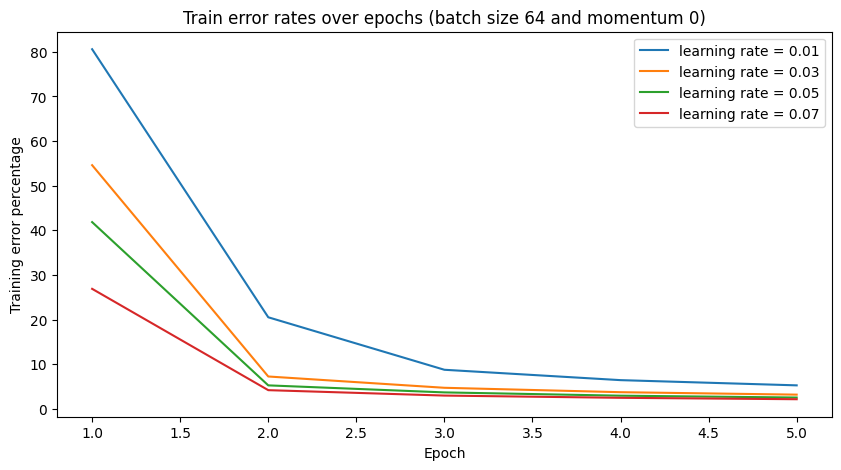

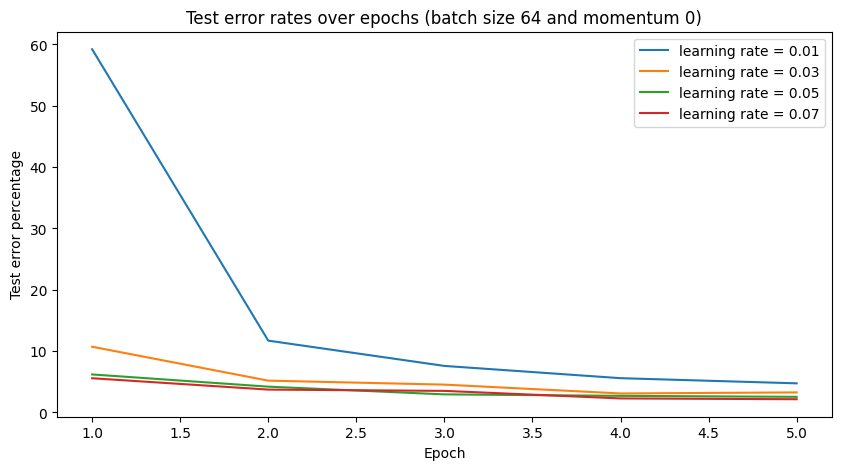

In [22]:
learning_rates_case1 = [0.01, 0.03, 0.05, 0.07]
vanilla_train_tuning_lr(batch_size=64, momentum=0, learning_rates=learning_rates_case1)

In the second case, 5 epochs over batch size 16 and momentum .75, we can see that the batch is much smaller than that of the first case. The smaller amount of batch elements might lead to more variance when updating the gradients and thus possible too fast training. Thus, the learning rates to compare the performances in this case should be relatively smaller. Also, the momentum is high at 0.75, so having smaller learning rates would make the training speed more stable.

Case: training nbatch = 16, momentum = 0.75
 training with learning rate = 0.001, training nbatch = 16, momentum = 0.75
 training with learning rate = 0.005, training nbatch = 16, momentum = 0.75
 training with learning rate = 0.01, training nbatch = 16, momentum = 0.75
 training with learning rate = 0.03, training nbatch = 16, momentum = 0.75


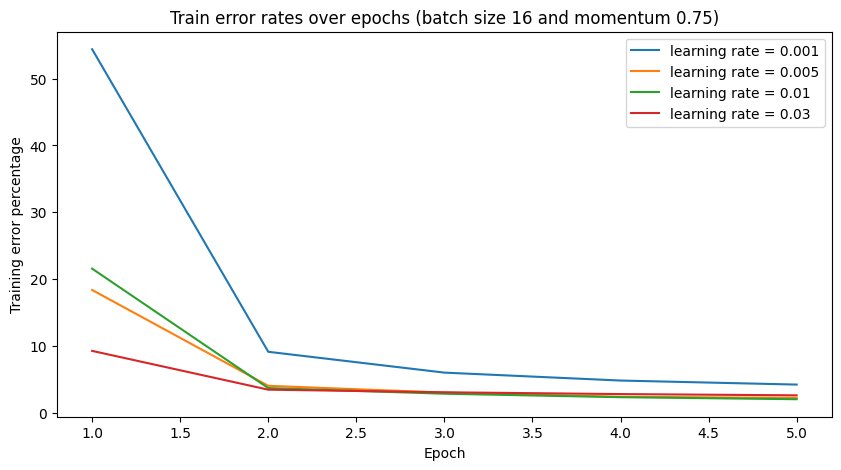

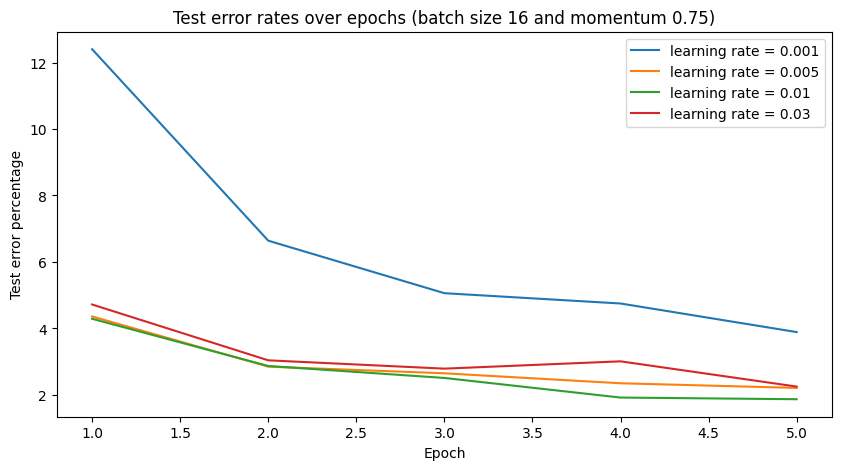

In [21]:
learning_rates_case2 = [0.001, 0.005, 0.01, 0.03]
vanilla_train_tuning_lr(batch_size=16, momentum=0.75, learning_rates=learning_rates_case2)

Given the results, we can observe that an interesting phenomenon. In the first case (batch size of 64 and momentum of 0), the overall "best" learning rate is not 0.01 and it is actually 0.07 (red curve) or the largest learning rate in the possible learning rates for comparison. This is different from what I expected. Over the epochs, both the train and test error rates for learning rate of 0.01 start from a high error rate and descend significantly. Meanwhile, the higher learning rates like 0.03, 0.05, and 0.07 give relatively more stable results in test error rates. Therefore, we can conclude that, given the fixed hyperparameters (batch size of 64, momentum of 0, kernel size of 3, depth of 1, and ReLU activation), the higher learning rates are associated with lower and more consistent error rates. It is likely that the batch size of 64 is very large and there is no momentum, thus the higher learning rates help with faster and concise convergence to the loss minimum.

In the second case (batch size of 16 and momentum of 0), the overall best learning rate is actually 0.01 (the green curve). This aligns with what I guessed earlier. Over the epochs, the learning rate of 0.01 give stable training and test error rates. Smaller learning rates like 0.001 and 0.005 are not performing well and there are big jumps across the first few epochs. Therefore, we can conclude that, given the fixed hyperparameters (batch size of 16, momentum of 0.75, kernel size of 3, depth of 1, and ReLU activation), the higher learning rates tend to give more stable and consistent results in training and test error rates. Nonetheless, different from case 1, the learning rate of 0.01 seems to be the best because now the batch size is smaller and the momentum is higher, which means we can possibly converge faster to the loss minimum. If we choose a too high learning rate, we can easily overshoot the global loss minimum in the test error rates. Therefore, the learning rate of 0.01 is more stable in this specific case.

**** Your solution goes above ****

We now consider increasing the depth of the network.  The following network has nine convolution layers.  It does not seem possible to find a learning rate that works well. (The test error 88.65% comes up a lot.  I'm guessing that is the random guessing error rate on the test data where the test data is not exactly unifromly distributed over the labels.)

In [23]:
model = PS2_CNN(3,3,nn.ReLU())
vanilla_train(model, 2, .3, 0, 64, train_dataset, test_dataset)
vanilla_train(model, 3, .07, 0, 64, train_dataset, test_dataset)

training nbatch = 064, lr = 0.30, momentum = 0.00
Epoch 001/002, Train Error 89.06% || Test Error 88.65%
Epoch 002/002, Train Error 89.02% || Test Error 88.65%
training nbatch = 064, lr = 0.07, momentum = 0.00
Epoch 001/003, Train Error 88.76% || Test Error 88.65%
Epoch 002/003, Train Error 88.76% || Test Error 88.65%
Epoch 003/003, Train Error 88.76% || Test Error 88.65%


You should now modify the nine layer network in the last cell to have a residual connection around each convolution layer. For the residual connections that require shape adjustment you can use the pytorch modules nn.avg_pool2d and F.pad. The package F contains functions with no trainable parameters.  See if you can find hyper-parameters for which the network trains.

*** your solution goes below ***

My implementation is below. Please note that I also included some of my descriptions and rationale explanations of the code near that code line as well.

In [24]:
class OneResidualBlock(nn.Module):

    # one block, in this case, contains one residual connection for one layer
    # remember: when we initiate the Conv2d in pytorch nn, it already intializes
    # the He weights for us to work from

    def __init__(self, nchannels_in, nchannels_out, kernel_dim, activation,
                 identity_downsample=False):
        super(OneResidualBlock, self).__init__()
        self.activation = activation
        self.conv = nn.Conv2d(nchannels_in, nchannels_out, kernel_dim,
                              stride=2 if identity_downsample else 1,
                              padding= int(kernel_dim/2)) # maintain the spatial size
        self.identity_downsample = identity_downsample

        # NOTE: a residual connection has two cases in this case
        # (1) residual connection within a stack has same dimensions (nchannels_in),
        # no need to downsample. In other words, it is just the output of the
        # previous layer (identity mapping). output of a previous layer
        # is directly added to the output of a subsequent layer within the
        # same stack.

        # (2) residual connection across stacks has different dimensions
        # (from nchannels_in to nchannels_out), need to downsample, this is a
        # convolutional layer to connect the last layer to the first ext layer
        # in the next stack

        # if we move from different stacks or have different dimensions between
        # layers. in other words, if downsample is True or
        # the nchannels_in != nchannels_out, adjust the input size

        if self.identity_downsample or nchannels_in != nchannels_out:
            # adjust the dimension
            # in this compose class, we first apply the AvgPool2d first to
            # reduce the spatial dimension of the data by half (stride=2)
            # then, we convert the channel dimension from nchannels_in to
            # nchannels_out using a convolution of kernel size 1x1
            self.residual_shape_adjust = compose(nn.Conv2d(nchannels_in,
                                                           nchannels_out,
                                                           kernel_size=1,
                                                           stride=1),
                                               nn.AvgPool2d(kernel_size=2,
                                                            stride=2))

    def forward(self, x):

        if self.identity_downsample:
            # if downsample (depth=1), this layer has to downsample the
            # residual connection
            residual_connection = self.residual_shape_adjust(x)
        else:
            # otherwise, residual_connection is just the input
            residual_connection = x

        # main convolutional path, F(x)
        Fx = self.conv(x)

        # now, check if there is any odd conversion (i.e. odd number when
        # downsampling with stride=2).
        # handle any remaining dimension mismatches between the main path
        # F(x) and residual (x) with padding
        if Fx.size() != residual_connection.size():
            # difference in height (vertical)
            diff_h = Fx.size(2) - residual_connection.size(2)
            # difference in width (horizontal)
            diff_w = Fx.size(3) - residual_connection.size(3)
            # https://pytorch.org/docs/stable/generated/torch.nn.functional.pad.html#torch.nn.functional.pad
            residual_connection = F.pad(residual_connection,
                                        # (left, right)
                                      [int(diff_w/2), diff_w-int(diff_w/2),
                                        # (top, bottom)
                                       int(diff_h/2), diff_h-int(diff_h/2)])

        # calculate the current output
        out = Fx + residual_connection    # F(x) + x
        out = self.activation(out)        # relu(F(x) + x)

        return out


def simple_stack(depth, nchannels_in, nchannels_out, kernel_dim, activation):
    # for this specific problem, each stack contains 3 layers, each layer has
    # a residual connection

    if depth == 1:
        # because depth=1, meaning we have to move to another stack with
        # different dimensions
        return OneResidualBlock(nchannels_in, nchannels_out, kernel_dim,
                                activation,
                                identity_downsample=True)

    return compose(
        simple_stack(depth-1, nchannels_in, nchannels_out, kernel_dim,
                     activation),
        OneResidualBlock(nchannels_in, nchannels_in, kernel_dim, activation,
                         identity_downsample=False)
    )


In [25]:
model = PS2_CNN(3,3,nn.ReLU())
vanilla_train(model, 2, .3, 0, 64, train_dataset, test_dataset)
print()
vanilla_train(model, 3, .07, 0, 64, train_dataset, test_dataset)
print()

# I experimented with lr=0.01 as well for nepochs=3 and nepochs=5
vanilla_train(model, 3, .01, 0, 64, train_dataset, test_dataset)
print()
vanilla_train(model, 5, .01, 0, 64, train_dataset, test_dataset)

training nbatch = 064, lr = 0.30, momentum = 0.00
Epoch 001/002, Train Error 41.55% || Test Error 13.33%
Epoch 002/002, Train Error 8.88% || Test Error 7.19%

training nbatch = 064, lr = 0.07, momentum = 0.00
Epoch 001/003, Train Error 4.12% || Test Error 3.47%
Epoch 002/003, Train Error 3.42% || Test Error 3.38%
Epoch 003/003, Train Error 3.03% || Test Error 3.18%

training nbatch = 064, lr = 0.01, momentum = 0.00
Epoch 001/003, Train Error 2.34% || Test Error 2.75%
Epoch 002/003, Train Error 2.17% || Test Error 2.72%
Epoch 003/003, Train Error 2.11% || Test Error 2.79%

training nbatch = 064, lr = 0.01, momentum = 0.00
Epoch 001/005, Train Error 2.01% || Test Error 2.59%
Epoch 002/005, Train Error 1.96% || Test Error 2.66%
Epoch 003/005, Train Error 1.91% || Test Error 2.63%
Epoch 004/005, Train Error 1.81% || Test Error 2.55%
Epoch 005/005, Train Error 1.86% || Test Error 2.64%


We can see from the results above that higher learning rates seem to be associated with higher error rates for both the train and test sets. I believe the learning rate of 0.01 and batch size of 64 seem to get robust results.

*** your solution goes above ***

Finally replace each addition in the residual connection with a convex combination with a trainable combination weight.  This is an experiemnt -- I'm not sure what to expect.

*** your solution goes below ***

My implementation is below. I included some explanation at the end as well.

In [26]:
class OneGatedResidualBlock(nn.Module):

    # one block, in this case, contains one residual connection for one layer

    def __init__(self, nchannels_in, nchannels_out, kernel_dim, activation,
                 identity_downsample=False):
        super(OneGatedResidualBlock, self).__init__()

        self.activation = activation
        self.conv = nn.Conv2d(nchannels_in, nchannels_out, kernel_dim,
                              stride=2 if identity_downsample else 1,
                              padding= int(kernel_dim/2)) # maintain the spatial size
        self.identity_downsample = identity_downsample

        # tanh and sigmoid
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()

        # NOTE: a residual connection has two cases in this case
        # (1) residual connection within a stack has same dimensions (nchannels_in),
        # no need to downsample. In other words, it is just the output of the
        # previous layer (identity mapping). output of a previous layer
        # is directly added to the output of a subsequent layer within the
        # same stack.

        # (2) residual connection across stacks has different dimensions
        # (from nchannels_in to nchannels_out), need to downsample, this is a
        # convolutional layer to connect the last layer to the first ext layer
        # in the next stack

        # if we move from different stacks or have different dimensions between
        # layers. in other words, if downsample is True or
        # the nchannels_in != nchannels_out, adjust the input size

        if self.identity_downsample or nchannels_in != nchannels_out:
            # adjust the dimension
            # in this compose class, we first apply the AvgPool2d first to
            # reduce the spatial dimension of the data by half (stride=2)
            # then, we convert the channel dimension from nchannels_in to
            # nchannels_out using a convolution of kernel size 1x1
            self.residual_shape_adjust = compose(nn.Conv2d(nchannels_in,
                                                           nchannels_out,
                                                           kernel_size=1,
                                                           stride=1),
                                                    nn.AvgPool2d(kernel_size=2,
                                                                 stride=2))

    def forward(self, x):

        if self.identity_downsample:
            # if downsample (depth=1), this layer has to downsample the
            # residual connection
            residual_connection = self.residual_shape_adjust(x)
        else:
            # otherwise, residual_connection is just the input
            residual_connection = x

        # main convolutional path, F(x)
        Fx = self.conv(x)

        # now, check if there is any odd conversion (i.e. odd number when
        # downsampling with stride=2)
        # handle any remaining dimension mismatches between the main path
        # F(x) and residual (x) with padding
        if Fx.size() != residual_connection.size():
            # difference in height (vertical)
            diff_h = Fx.size(2) - residual_connection.size(2)
            # difference in width (horizontal)
            diff_w = Fx.size(3) - residual_connection.size(3)
            # https://pytorch.org/docs/stable/generated/torch.nn.functional.pad.html#torch.nn.functional.pad
            residual_connection = F.pad(residual_connection,
                                        # (left, right)
                                      [int(diff_w/2), diff_w-int(diff_w/2),
                                       # (top, bottom)
                                       int(diff_h/2), diff_h-int(diff_h/2)])

        # raw state (transformed residual)
        Rx = self.tanh(Fx + residual_connection)

        # gating: if Gate near 1, emphasizes the output from the convolutional
        # layer F(x)
        # if Gate near 0, emphasizes the output from the residual Rx
        Gate = self.sigmoid(Fx + residual_connection)

        # final output with convex combination of Gate
        out = Gate * Fx + (1 - Gate) * Rx

        return out


def simple_stack(depth, nchannels_in, nchannels_out, kernel_dim, activation):
    # for this specific problem, each stack contains 3 layers, each layer has a
    # residual connection

    if depth == 1:
        # because depth=1, meaning we have to move to another stack with
        # different dimensions
        return OneGatedResidualBlock(nchannels_in, nchannels_out, kernel_dim,
                                     activation, identity_downsample=True)

    return compose(
        simple_stack(depth-1, nchannels_in, nchannels_out, kernel_dim,
                     activation),
        OneGatedResidualBlock(nchannels_in, nchannels_in, kernel_dim,
                              activation, identity_downsample=False)
    )


In [27]:
model = PS2_CNN(3,3,nn.ReLU())
vanilla_train(model, 2, .3, 0, 64, train_dataset, test_dataset)
print()
vanilla_train(model, 3, .07, 0, 64, train_dataset, test_dataset)
print()

# I experimented with lr=0.01 as well for nepochs=3 and nepochs=5
vanilla_train(model, 3, .01, 0, 64, train_dataset, test_dataset)
print()
vanilla_train(model, 5, .01, 0, 64, train_dataset, test_dataset)

training nbatch = 064, lr = 0.30, momentum = 0.00
Epoch 001/002, Train Error 14.93% || Test Error 4.33%
Epoch 002/002, Train Error 3.27% || Test Error 3.91%

training nbatch = 064, lr = 0.07, momentum = 0.00
Epoch 001/003, Train Error 1.24% || Test Error 1.46%
Epoch 002/003, Train Error 0.93% || Test Error 1.27%
Epoch 003/003, Train Error 0.74% || Test Error 1.35%

training nbatch = 064, lr = 0.01, momentum = 0.00
Epoch 001/003, Train Error 0.42% || Test Error 1.18%
Epoch 002/003, Train Error 0.38% || Test Error 1.25%
Epoch 003/003, Train Error 0.35% || Test Error 1.21%

training nbatch = 064, lr = 0.01, momentum = 0.00
Epoch 001/005, Train Error 0.33% || Test Error 1.25%
Epoch 002/005, Train Error 0.31% || Test Error 1.21%
Epoch 003/005, Train Error 0.31% || Test Error 1.23%
Epoch 004/005, Train Error 0.28% || Test Error 1.25%
Epoch 005/005, Train Error 0.25% || Test Error 1.25%


Convex combination with Tanh and Sigmoid. I followed the Gating mechanism in slide 17 in https://mcallester.github.io/ttic-31230/05RNNs/LangModels.pdf. We can see from the results that the residual connection with a convex combination gives lower and more consistent error rates overall than the residual connection without a convex combination in the last part. The consistency is more stable as we use lower learning rates. This might be due to the fact that this method allows the model to adaptively weight the contribution of different features. It introduces non-linearity as implicit regularization, likely helping the model filter out noise.